**Material parameters for Moresi el al (2014)**

This notebook outlines the material parameterisation used to model the dynamics of continental accretion as shown in Extended Data Figure 2 of [Moresi et al (2014) [doi:10.1038/nature13033](https://www.nature.com/articles/nature13033)

A number of functions must be defined
1. layer intersects of discretised lithospheric structure, a numpy array with dimensions of length [L]
2. depth, a numpy array with dimensions of length [L]
3. crustal density, rho(depth), a numpy array with dimensions of [M/L^3] 
4. temperature, temperature(depth), a numper array with dimensions of [T]
5. yield strength, yieldStrength(pressure), a numpy array with dimensions of pressure []. Pressure assumed to be lithostatic pressure.
6. softened yield strength, yieldStrength2(pressure), a numpy array with dimensions of pressure []. Pressure assumed to be lithostatic pressure.
7. viscous deformation law?

In [1]:
import underworld as uw
from underworld import function as fn

import numpy as np
import math
import scipy
import scipy.special as special
import os
import matplotlib.pyplot as pypl
import pint

import material_plots as plot

In [2]:
u = pint.UnitRegistry()

**Define the layer intersections in the modelled lithosphere**

In [3]:
# for oceanic lithosphere, ExFig 5a, 5b
layers = np.array([0, 25, 50, 75, 100, 200]) * 10**3 * u.meter 
print('Numer of layers is {}'.format(len(layers)-1))
print('Interface at {}'.format(layers.to('kilometer')))

Numer of layers is 5
Interface at [   0.   25.   50.   75.  100.  200.] kilometer


**Define depth**

In [4]:
res   = 251
depth = np.linspace(0, 250., res) * 10**3 * u.meter

**Define density**

In [5]:
# oceanic lithosphere
crustThickness  = 7.0  * u.kilometer
crustDensity    = 2900 * u.kilogram / u.meter**3 # Oceanic crust (cold basalt)
# crustDensity    = 3400 * u.kilogram / u.meter**3 # Eclogite

mantleDensity   = 3400 * u.kilogram / u.meter**3  # (cold)  
rho = np.ones(res)* u.kilogram / u.meter**3

In [6]:
def rho_fun(depth):
    for index, y in enumerate(depth):
        if y > crustThickness:
            rho[index] = mantleDensity
        else:
            rho[index] = crustDensity

In [7]:
rho_fun(depth)

**Define temperature**

In [8]:
Tsurf = 273.15 * u.degK
Tint  = 1573.0 * u.degK
kappa = 1e-6   * u.meter**2 / u.second 
alpha = 3.0e-5 / u.kelvin

grav  = 9.81   * u.meter / u.second**2
R     = 8.314  * u.joule / u.degK / u.mol

# age of oceanic lithosphere
age =  80. * 10**6 * u.year

# temperature of oceanic lithosphere thickness
def half_space_cooling(depth,age):
    return Tsurf +(Tint-Tsurf) * special.erf(depth/(2*np.sqrt(age*kappa)))

# temperature of cratonic lithosphere
def craton_linear_geotherm(depth):
    linear = depth.to('kilometer')*(Tint-Tsurf)/(150.*u.kilometer)+Tsurf
    return np.minimum(linear.magnitude,Tint)*linear.units

# temperature of transition lithosphere
def transition_linear_geotherm(depth):
    linear = depth.to('kilometer')*(Tint-Tsurf)/(100.*u.kilometer)+Tsurf
    return np.minimum(linear.magnitude,Tint)*linear.units

# temperature of backarc lithosphere
def backarc_linear_geotherm(depth):
    linear = depth.to('kilometer')*(Tint-Tsurf)/(80.*u.kilometer)+Tsurf
    return np.minimum(linear.magnitude,Tint)*linear.units

In [9]:
# define temperature for half-space-cooling model
temperature = half_space_cooling(depth.to_base_units(), age.to_base_units())

**Define denisty with depth**

In [10]:
def density_fun():
    deltaT  = temperature - Tsurf
    density = rho - rho * deltaT * alpha
    return density

In [11]:
density = density_fun()

**Define pressure with depth**

In [12]:
pressure = density * grav * depth

**Define yield criteria**

In [13]:
# oceanic lithosphere       
cohesion = 12.5 * u.megapascal

friction = 0.0666
cohesion2 = cohesion/2.
friction2 = friction/2.  # is this needed for the oceanic lithosphere?

In [14]:
yieldStrength  = cohesion  + friction  * pressure
yieldStrength2 = cohesion2 + friction2 * pressure # post yeild strength

**Define viscous deformation**

In [15]:
# wet diffusion creep - Karato & Wu, 1993
A = 5.3  * 10**15 / u.pascal / u.second
E = 240. * 10**3 * u.joule / u.mol
V = 5.0  * 1e-6 * u.meter**3 / u.mol

max_viscosity = 1.e5

def arrhenius(T,P):
    return np.exp((E + V*P)/(R*T))

In [16]:
# define some reference parameters
ref_depth     = 100. * 10**3 *u.meter   
ref_pressure  = mantleDensity * grav * ref_depth
ref_temp      = Tint
ref_viscosity = arrhenius(ref_temp, ref_pressure)
ref_density   = mantleDensity * (Tint-Tsurf) * alpha

In [17]:
# calculate viscosity profile
viscosity = np.clip(arrhenius(temperature, pressure)/ref_viscosity, a_min = 1., a_max = max_viscosity) 

In [18]:
# calculate averages of layers
avg_depth      = []
avg_temp       = []
avg_density    = []
avg_pressure   = []
avg_viscosity  = []
avg_strength   = []
low_strength   = []
avg_strength2  = []
low_strength2  = []

def calc_layers():
    prevIndex = 0
    for i, interface in enumerate(layers):
        if( interface > 250.*u.kilometer):
            break
        index = np.where(depth.magnitude==interface.magnitude)[0][0]
        if depth[index].magnitude > 0.:
            avg_depth.append(     np.average(depth.to('km').magnitude[prevIndex:index]))
            avg_temp.append(      np.average(temperature[prevIndex:index]))
            avg_density.append((  np.average(density[ prevIndex: index])-(density[-1]).magnitude)/ref_density.magnitude)
            avg_pressure.append(  np.average(pressure.to('MPa').magnitude[prevIndex:index]))
            avg_viscosity.append( np.average(viscosity.magnitude[prevIndex:index]))
            avg_strength.append(  np.average(yieldStrength.to('MPa').magnitude[prevIndex:index]))
            avg_strength2.append( np.average(yieldStrength2.to('MPa').magnitude[prevIndex:index]))
            low_strength.append(  np.min(    yieldStrength.to('MPa').magnitude[prevIndex:index]))
            low_strength2.append( np.min(    yieldStrength2.to('MPa').magnitude[prevIndex:index]))
        prevIndex = index

In [19]:
calc_layers()

**Plot material properties within layers**

In [20]:
def plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer):
    figure1 = pypl.figure(figsize=(12,8))
    figure1.suptitle(title, fontsize=14, fontweight='bold')

    # Temperature and Viscosity profiles
    tempPlot = figure1.add_subplot(131)
    tempPlot.plot(temperature.to('degC'), depth.to('kilometer'), color='green', linestyle='solid', linewidth=2, label='')
    tempPlot.set_xlabel('Temperature (C)')
    tempPlot.set_ylabel('Depth (kilometer)')
    tempPlot.set_xlim(0,1500)
    tempPlot.set_ylim(250, 0)
    tempPlot.set_yticks([0,25,50,75,100,200,250])
    tempPlot.grid(axis='y')

    viscPlot = tempPlot.twiny()
    viscPlot.plot(np.log10(viscosity), depth.to('kilometer'), color='blue', linestyle='solid', linewidth=2)
    viscPlot.set_xlabel('log$_{10}$ relative viscosity')
    viscPlot.set_xlim(0, 7)
    viscPlot.set_ylim(0, 250)
    viscPlot.invert_yaxis()
    viscPlot.barh(layers.magnitude[0:-1]/10**3,np.log10(avg_viscosity[0:]), height=height, left=0.0, alpha=0.5, align="edge")

    # Density profile
    densityPlot = figure1.add_subplot(132)
    densityPlot.plot(density, depth.to('kilometer'), color='red' , linestyle='solid', linewidth=2)
    densityPlot.set_xlabel('Density (kg/m$^3$)')
    densityPlot.set_xlim(densityPlot_xlim)
    densityPlot.set_ylim(0, 250)
    densityPlot.invert_yaxis()
    densityPlot.set_yticks([0,25,50,75,100,200,250])
    densityPlot.grid(axis='y')

    relDensityPlot = densityPlot.twiny()
    relDensityPlot.set_xlabel('Relative density')
    relDensityPlot.set_xlim(relDensityPlot_xlim)
    relDensityPlot.axvline(x=0, ymin=0, ymax=1, linestyle='dotted', color='black')
    relDensityPlot.set_ylim(250,0)
    relDensityPlot.barh(layers[0:-1]/10**3,avg_density[0:], height=height, left=0.0, alpha=0.5, color='#FF2222', align="edge")

    # lithostatic pressure and strength profile
    pressurePlot = figure1.add_subplot(133)
    pressurePlot.set_xlabel('Pressure (Mpa)')
    pressurePlot.set_yticks([0,25,50,75,100,200,250])
    pressurePlot.plot(pressure.to('MPa'), depth.to('kilometer'), color='DarkGreen', linestyle='dashed', linewidth=2)
    pressurePlot.set_xticks([0,2500,5000,7500,10000])
    pressurePlot.set_ylim(0, 250)
    pressurePlot.invert_yaxis()
    pressurePlot.set_xlim(0, 7500)
    pressurePlot.grid(axis='y')

    strengthPlot = pressurePlot.twiny()
    strengthPlot.set_xlabel('Yield strength (Mpa)')
    strengthPlot.set_ylim(250,0)
    strengthPlot.set_xlim(strengthPlot_xlim)
    strengthPlot.plot(yieldStrength.to('MPa'), depth.to('kilometer'), color='green', linestyle='solid', linewidth=2, label='Yield strength (MPa)')
    strengthPlot.barh(layers[0:viz_strength_layer]/10**3, low_strength[0:viz_strength_layer], 
                      height=height[0:viz_strength_layer], left=0.0, alpha=0.5, color='green', align="edge")
    strengthPlot.barh(layers[0:viz_strength_layer]/10**3, low_strength2[0:viz_strength_layer], 
                      height=height[0:viz_strength_layer], left=0.0, alpha=0.5, color='darkgreen', align="edge")


**Figure 2(a) Half-space cooling - 80 Myr Oceanic Lithosphere**

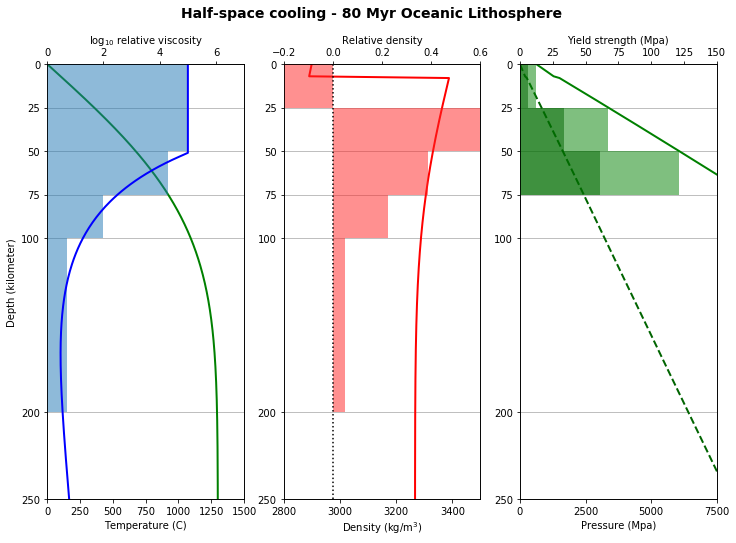

In [21]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - 80 Myr Oceanic Lithosphere'
densityPlot_xlim    = (2800,3500)
relDensityPlot_xlim = (-0.2, 0.6)
strengthPlot_xlim   = (0, 150)
viz_strength_layer  = 3

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [22]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.3e};\t {2:.3e};\t {3:.3e};\t {4:.3e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - 80 Myr Oceanic Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
25.0;	 1.000e+05;	 -3.388e-01;	 1.250e+01;	 6.250e+00;	
50.0;	 1.000e+05;	 6.040e-01;	 6.744e+01;	 3.372e+01;	
75.0;	 1.930e+04;	 3.849e-01;	 1.213e+02;	 6.066e+01;	
100.0;	 9.641e+01;	 2.228e-01;	 1.745e+02;	 8.725e+01;	
200.0;	 5.030e+00;	 5.059e-02;	 2.274e+02;	 1.137e+02;	


In [23]:
avg_depth      = []
avg_temp       = []
avg_density    = []
avg_pressure   = []
avg_viscosity  = []
avg_strength   = []
low_strength   = []
avg_strength2  = []
low_strength2  = []


**Figure 2(b) Half-space cooling - 120 Myr Oceanic Lithosphere**

In [24]:
age = 120. * 10**6 * u.year
temperature = half_space_cooling(depth.to_base_units(), age.to_base_units())
viscosity = np.clip(arrhenius(temperature, pressure)/ref_viscosity, a_min = 0, a_max = max_viscosity) 

In [25]:
calc_layers()

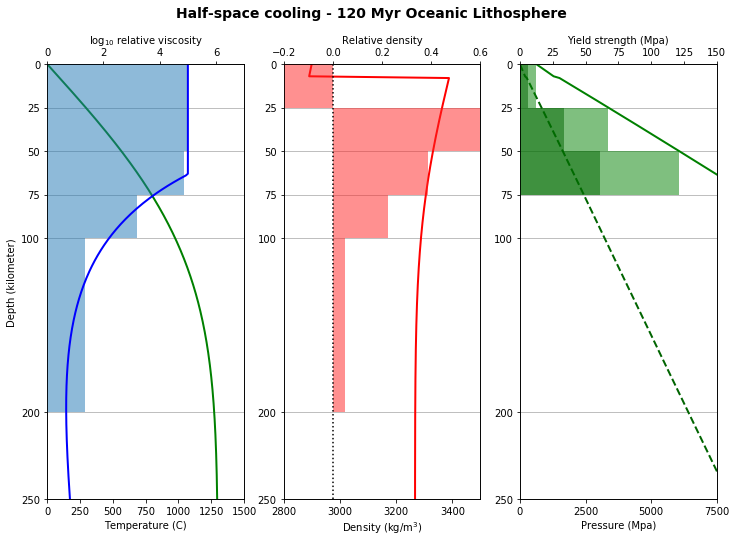

In [26]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - 120 Myr Oceanic Lithosphere'
densityPlot_xlim    = (2800,3500)
relDensityPlot_xlim = (-0.2, 0.6)
strengthPlot_xlim   = (0, 150)
viz_strength_layer  = 3

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [27]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.3e};\t {2:.3e};\t {3:.3e};\t {4:.3e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - 120 Myr Oceanic Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
25.0;	 1.000e+05;	 -3.388e-01;	 1.250e+01;	 6.250e+00;	
50.0;	 1.000e+05;	 6.040e-01;	 6.744e+01;	 3.372e+01;	
75.0;	 7.032e+04;	 3.849e-01;	 1.213e+02;	 6.066e+01;	
100.0;	 1.587e+03;	 2.228e-01;	 1.745e+02;	 8.725e+01;	
200.0;	 2.259e+01;	 5.059e-02;	 2.274e+02;	 1.137e+02;	


In [28]:
avg_depth      = []
avg_temp       = []
avg_density    = []
avg_pressure   = []
avg_viscosity  = []
avg_strength   = []
low_strength   = []
avg_strength2  = []
low_strength2  = []

**Figure 2(c) Cratonic Lithosphere**

In [29]:
# define layers
layers = np.array([0, 75, 150, 200]) * 10**3 * u.meter 

# define crust thickness and density
crustThickness  = 40.0  * u.kilometer
crustDensity    = 2700 * u.kilogram / u.meter**3 

In [30]:
temperature = craton_linear_geotherm(depth)

# define density (reference and with depth)
rho_fun(depth)
density = density_fun()

max_viscosity = 5.e3
viscosity = np.clip(arrhenius(temperature, pressure)/ref_viscosity, a_min = 0, a_max = max_viscosity) 

In [31]:
# cratonic lithosphere strength profiles
yieldStrength  = np.ones(res)*130.*u.megapascal
yieldStrength2 = yieldStrength/2.

In [32]:
calc_layers()

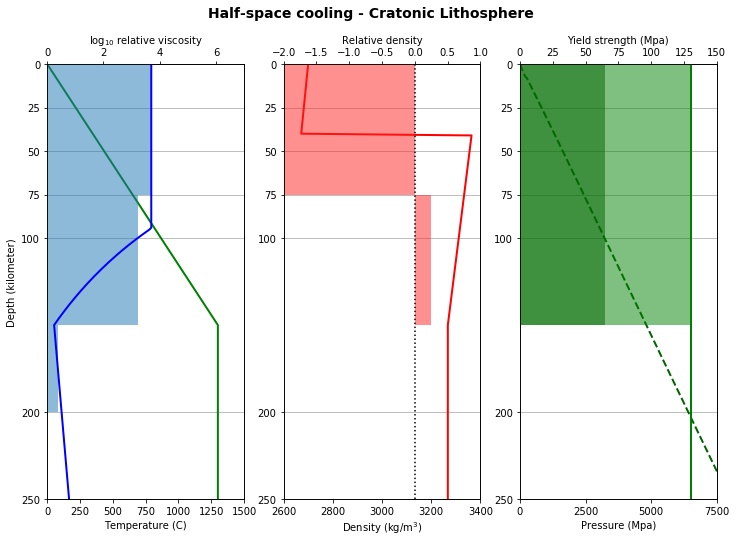

In [33]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - Cratonic Lithosphere'
densityPlot_xlim    = (2600,3400)
relDensityPlot_xlim = (-2.0, 1.0)
strengthPlot_xlim   = (0, 150)
viz_strength_layer  = 2

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [34]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.3e};\t {2:.3e};\t {3:.3e};\t {4:.3e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - Cratonic Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
75.0;	 5.000e+03;	 -2.118e+00;	 1.300e+02;	 6.500e+01;	
150.0;	 1.675e+03;	 2.533e-01;	 1.300e+02;	 6.500e+01;	
200.0;	 2.411e+00;	 -3.430e-15;	 1.300e+02;	 6.500e+01;	


In [35]:
avg_depth      = []
avg_temp       = []
avg_density    = []
avg_pressure   = []
avg_viscosity  = []
avg_strength   = []
low_strength   = []
avg_strength2  = []
low_strength2  = []

**Figure 2(d) Transitional Lithosphere**

In [36]:
# define layers
layers = np.array([0, 50, 100, 200]) * 10**3 * u.meter 

# # transition lithosphere
crustThickness  = 25.0  * u.kilometer
crustDensity    = 2700 * u.kilogram / u.meter**3 

temperature = transition_linear_geotherm(depth)
# define density (reference and with depth)
rho_fun(depth)
density = density_fun()

max_viscosity = 5.e3
viscosity = np.clip(arrhenius(temperature, pressure)/ref_viscosity, a_min = 0, a_max = max_viscosity) 

In [37]:
# transitional lithosphere strength profiles
yieldStrength = np.zeros(res)*u.megapascal
def trans_yeildStrength(depth):
    for index, y in enumerate(depth):
        if y < 50.*u.kilometer:
            yieldStrength[index] = 40.*u.megapascal
        elif y < 100.*u.kilometer:
            yieldStrength[index] = 150.*u.megapascal
    return yieldStrength

# yieldStrength  = np.ones(res)*40.*u.megapascal
trans_yeildStrength(depth)
yieldStrength2 = yieldStrength/2.

In [38]:
#avg_depth, avg_temp, avg_density, avg_pressure, avg_viscosity, avg_strength, avg_strength2, low_strength, low_strength2 = calc_layers()
calc_layers()

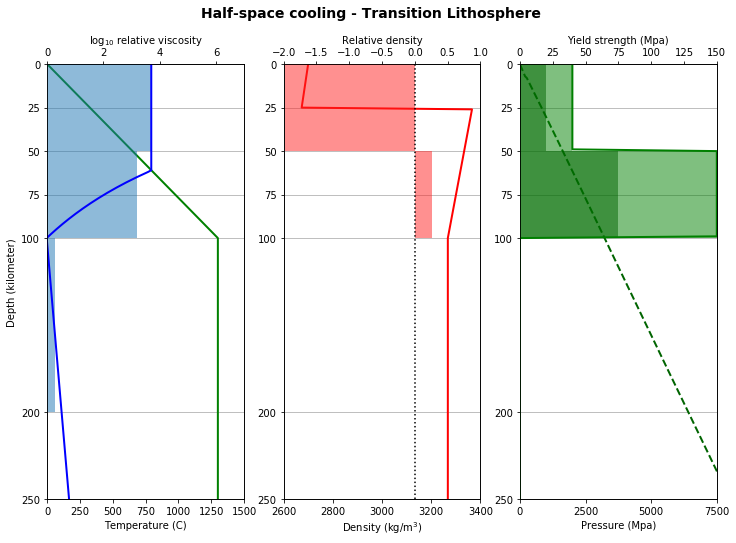

In [39]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - Transition Lithosphere'
densityPlot_xlim    = (2600,3400)
relDensityPlot_xlim = (-2.0, 1.0)
strengthPlot_xlim   = (0, 150)
viz_strength_layer  = 2

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [40]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.3e};\t {2:.3e};\t {3:.3e};\t {4:.3e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - Transition Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
50.0;	 5.000e+03;	 -1.977e+00;	 4.000e+01;	 2.000e+01;	
100.0;	 1.502e+03;	 2.550e-01;	 1.500e+02;	 7.500e+01;	
200.0;	 1.861e+00;	 -3.430e-15;	 0.000e+00;	 0.000e+00;	


In [41]:
avg_depth      = []
avg_temp       = []
avg_density    = []
avg_pressure   = []
avg_viscosity  = []
avg_strength   = []
low_strength   = []
avg_strength2  = []
low_strength2  = []

**Figure 2(e) Weak back-arc Lithosphere**

In [42]:
# define layers
layers = np.array([0, 50, 100, 200]) * 10**3 * u.meter 

# back-arc lithosphere
crustThickness  = 20.0  * u.kilometer
crustDensity    = 2800 * u.kilogram / u.meter**3 

def backarc_linear_geotherm2(depth):
    linear = depth.to('kilometer')*(Tint-Tsurf)/(80.*u.kilometer)+Tsurf
    return np.minimum(linear.magnitude,Tint)*linear.units

temperature = backarc_linear_geotherm2(depth)

# define density (reference and with depth)
rho_fun(depth)
density = density_fun()

max_viscosity = 5.e3
viscosity = np.clip(arrhenius(temperature, pressure)/ref_viscosity, a_min = 0, a_max = max_viscosity) 

In [43]:
# back arc weak
yieldStrength = np.zeros(res)*u.megapascal
def backarc_yeildStrength(depth):
    for index, y in enumerate(depth):
        if y < 50.*u.kilometer:
            yieldStrength[index] = 12.5*u.megapascal
        elif y < 100.*u.kilometer:
            yieldStrength[index] = 25.0*u.megapascal
    return yieldStrength

backarc_yeildStrength(depth)
yieldStrength2 = yieldStrength/2.

In [44]:
#avg_depth, avg_temp, avg_density, avg_pressure, avg_viscosity, avg_strength, avg_strength2, low_strength, low_strength2 = calc_layers()
calc_layers()


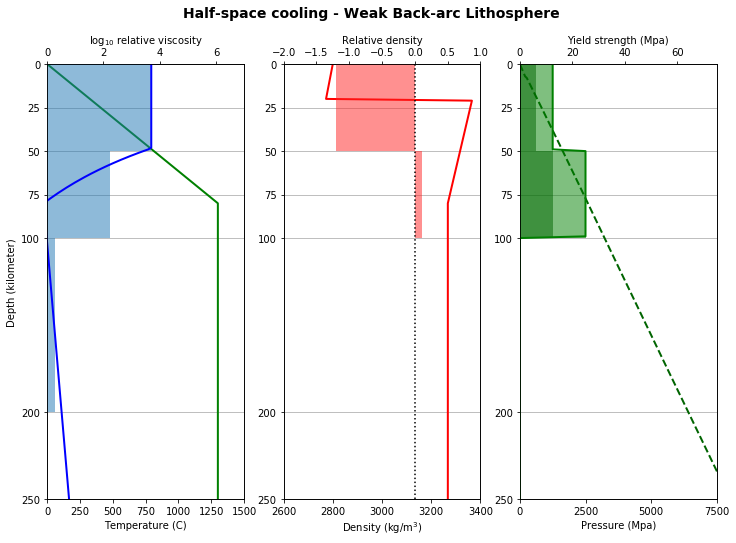

In [45]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - Weak Back-arc Lithosphere'
densityPlot_xlim    = (2600,3400)
relDensityPlot_xlim = (-2.0, 1.0)
strengthPlot_xlim   = (0, 75)
viz_strength_layer  = 2

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [46]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.3e};\t {2:.3e};\t {3:.3e};\t {4:.3e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - Weak Back-arc Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
50.0;	 4.978e+03;	 -1.198e+00;	 1.250e+01;	 6.250e+00;	
100.0;	 1.726e+02;	 1.162e-01;	 2.500e+01;	 1.250e+01;	
200.0;	 1.861e+00;	 -3.430e-15;	 0.000e+00;	 0.000e+00;	


In [47]:
avg_depth      = []
avg_temp       = []
avg_density    = []
avg_pressure   = []
avg_viscosity  = []
avg_strength   = []
low_strength   = []
avg_strength2  = []
low_strength2  = []

**Figure 2(e) Strong back-arc Lithosphere**

In [48]:
# back arc strong
yieldStrength = yieldStrength * 2.
yieldStrength2 = yieldStrength2 * 2.

In [49]:
#avg_depth, avg_temp, avg_density, avg_pressure, avg_viscosity, avg_strength, avg_strength2, low_strength, low_strength2 = calc_layers()
calc_layers()


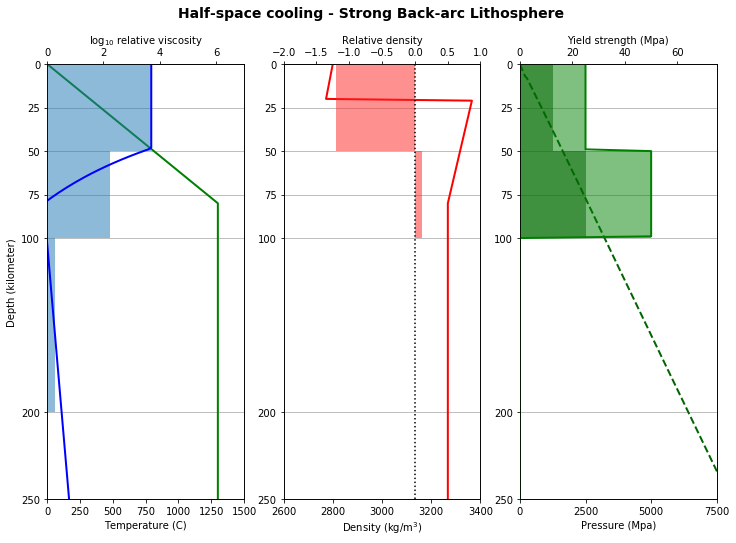

In [50]:
height=(layers.magnitude[1:] - layers.magnitude[0:-1])/1e3
title = 'Half-space cooling - Strong Back-arc Lithosphere'
densityPlot_xlim    = (2600,3400)
relDensityPlot_xlim = (-2.0, 1.0)
strengthPlot_xlim   = (0, 75)
viz_strength_layer  = 2

plot(title,height,densityPlot_xlim,relDensityPlot_xlim,strengthPlot_xlim,viz_strength_layer)

In [51]:
print(title)
print('layer\t avg_viscosity\t avg_density\t low_strength\t low_strength2 ')
for i, j in enumerate(avg_viscosity):
    print('{0:.1f};\t {1:.3e};\t {2:.3e};\t {3:.3e};\t {4:.3e};\t'
          .format(layers.magnitude[i+1]/1e3, avg_viscosity[i], avg_density[i], low_strength[i], low_strength2[i]))

Half-space cooling - Strong Back-arc Lithosphere
layer	 avg_viscosity	 avg_density	 low_strength	 low_strength2 
50.0;	 4.978e+03;	 -1.198e+00;	 2.500e+01;	 1.250e+01;	
100.0;	 1.726e+02;	 1.162e-01;	 5.000e+01;	 2.500e+01;	
200.0;	 1.861e+00;	 -3.430e-15;	 0.000e+00;	 0.000e+00;	
